# Coordinate reference system management

In this chapter, we focus on understanding how the coordinate reference system (CRS) can be managed with raster data using `rioxarray` library. As we discussed in Chapter 5.3, the process of attaching information about a location to a piece of information is commonly referred as *{term}`georeferencing`*. When considering raster data, there are ultimately two relevant parts to the georeferencing of a raster dataset: 

1. the definition of the local, regional, or global system in which a raster’s pixels are located (CRS), and
2. the parameters by which pixel coordinates are transformed into coordinates in that system.

In the following, we will focus on inspecting different kinds of georeferencing metadata that are supported by `rioxarray`/`rasterio`, as well as learn how to reproject a raster from one coordinate reference system to another which is a commonly needed GIS technique when doing geographic data analysis. 

## Georeferencing raster data - Key concepts

As we have seen from the previous chapters, raster data represents spatial information as a grid of pixels, commonly used for satellite imagery, elevation models, and land cover maps. However, for a raster to be meaningful in a geographic context, it must be correctly georeferenced. Georeferencing ensures that each pixel corresponds to a specific location on Earth. There are a few central concepts related to georeferencing raster data: the *{term}`coordinate reference system` (CRS)*, the *{term}`transform`* and the *{term}`affine`*. Understanding these concepts is crucial for working with spatial data, as they define how a raster aligns with real-world locations.

- The ***CRS*** defines the spatial reference of the raster, specifying how coordinates are measured. It includes a datum (e.g. WGS84) and a projection (e.g. UTM) that determine how the Earth's curved surface is represented in a flat raster dataset. Without a CRS, a raster lacks geographic context.
- The ***transform*** describes how pixel coordinates (row, column) map to real-world coordinates (e.g., meters or degrees). It defines the raster’s scale, rotation, and location.
- The ***affine*** transformation is a mathematical model commonly used in Python to define the spatial transformation of raster data. It consists of six parameters that control translation (position), scaling (resolution), and rotation/skew. 

In addition to these concepts, a raster dataset may also be georeferenced using *{term}`Ground Control Points` (GCP)* or *{term}`Rational Polynomial Coefficients` (RPCs)*. Ground Control Points are known locations on the Earth's surface with accurately measured coordinates using e.g. GPS device or derived from high-resolution reference image. They are used to improve georeferencing accuracy by linking raster pixel positions to real-world coordinates. GCPs help correct distortions in aerial or satellite images by creating polynomial transformations. Typically a dataset will have multiple GCPs distributed across the image. 

Rational Polynomial Coefficients (RPCs) provide an alternative georeferencing method, often used for high-resolution satellite imagery. Instead of an affine transform, RPCs model the relationship between image coordinates and real-world coordinates using rational polynomial coefficients which are typically provided by satellite image providers. They allow for more complex transformations, especially in cases where elevation variations affect image positioning. 


## Extracting geoferencing / CRS attributes

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

fp = "data/temp/kilimanjaro_dataset.nc"

data = xr.open_dataset(fp, decode_coords="all")
data

<xarray.Dataset> Size: 156MB
Dimensions:          (y: 3601, x: 3601)
Coordinates:
  * x                (x) float64 29kB 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0
  * y                (y) float64 29kB -2.0 -2.0 -2.001 ... -2.999 -3.0 -3.0
    spatial_ref      int32 4B ...
Data variables:
    elevation        (y, x) float64 104MB ...
    relative_height  (y, x) float32 52MB ...

In [2]:
data.spatial_ref.attrs

{'crs_wkt': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]',
 'semi_major_axis': 6378137.0,
 'semi_minor_axis': 6356752.314245179,
 'inverse_flattening': 298.257223563,
 'reference_ellipsoid_name': 'WGS 84',
 'longitude_of_prime_meridian': 0.0,
 'prime_meridian_name': 'Greenwich',
 'geographic_crs_name': 'WGS 84',
 'horizontal_datum_name': 'World Geodetic System 1984',
 'grid_mapping_name': 'latitude_longitude',
 'spatial_ref': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]',
 'Geo

In [3]:
data.rio.crs

CRS.from_epsg(4326)

In [4]:
data.rio.crs.to_epsg()

4326

In [5]:
data.rio.crs.to_wkt()

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

In [6]:
# Affine transform (how raster is scaled, rotated, skewed, and/or translated)
affine = data.rio.transform()
affine

Affine(0.0002777777777777778, 0.0, 35.9998611111111,
       0.0, -0.0002777777777777781, -1.99986111111111)

In [7]:
# Pixel size
print("Pixel size x-direction (a):", affine.a)
print("Pixel size y-direction (e):", affine.e)

Pixel size x-direction (a): 0.0002777777777777778
Pixel size y-direction (e): -0.0002777777777777781


In [8]:
# Rotation/skew
print("Rotation/skew x-direction (b):", affine.b)
print("Rotation/skew y-direction (d):", affine.d)

Rotation/skew x-direction (b): 0.0
Rotation/skew y-direction (d): 0.0


In [9]:
# Top-left corner's real-world coordinates
print("X-coordinate of the top-left pixel (c):", affine.c)
print("Y-coordinate of the top-left pixel (f):", affine.f)

X-coordinate of the top-left pixel (c): 35.9998611111111
Y-coordinate of the top-left pixel (f): -1.99986111111111


## Estimating the UTM zone of a raster

As we saw previously, our `Dataset` currently has a `WGS84` coordinate reference system (EPSG:4326) in which the coordinates are represented as decimal degrees. For various reasons, you might want to reproject your data into a metric CRS, such as national coordinate reference frames (e.g. EUREF-FIN in Finland) or Universal Transverse Mercator (UTM) coordinate system which divides the Earth into 60 zones and projects each one to a plane (Figure 7.20). Most zones in UTM span 6 degrees of longitude, and each has a designated central meridian. UTM zones are widely used in (geographically) large countries, such as in United States and Canada to represent geographic data in a metric coordinate reference system. 

![_**Figure 7.20.** Universal Transverse Mercator (UTM) zones on an equirectangular world map with irregular zones labeled in red. Image source: cmglee, STyx, Wikialine and Goran tek-en (2019) via Wikimedia Commons, licensed under Creative Commons BY-SA 4.0._](../img/UTM_zones.png)

_**Figure 7.20.** Universal Transverse Mercator (UTM) zones on an equirectangular world map with irregular zones labeled in red. Image source: cmglee, STyx, Wikialine and Goran tek-en (2019) via Wikimedia Commons, licensed under Creative Commons BY-SA 4.0._

It is relatively common to use UTM coordinate reference system especially when working with raster data that covers large areas on a sub-national level. However, many datasets are typically distributed in WGS84, which means that you need to know the UTM zone for a given area that covers the raster dataset before you can reproject the data into metric system. Luckily, `rioxarray` includes a handy method called `.rio.estimate_utm_crs()` that makes it possible to make a sophisticated guess of the UTM-zone that the data falls under. In the following, we will find out the UTM-zone for our raster dataset located in Tanzania:

In [19]:
utm_crs = data.rio.estimate_utm_crs()
utm_crs

CRS.from_epsg(32737)

In [20]:
utm_crs.to_wkt()

'PROJCS["WGS 84 / UTM zone 37S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",39],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32737"]]'

As we can see, the EPSG-code for our dataset is `32737` which belongs to UTM zone 37S which is correctly identified. Notice that if your data covers large areas that span across multiple UTM zones, it might not be possible to identify the UTM zone for such data. 

## Reprojecting raster data

To reproject, the data we can use the `.rio.reproject()` method. 

In [16]:
data_utm = data.rio.reproject("EPSG:32737")
data_utm

<xarray.Dataset> Size: 156MB
Dimensions:          (x: 3618, y: 3598)
Coordinates:
  * x                (x) float64 29kB 1.662e+05 1.663e+05 ... 2.777e+05
  * y                (y) float64 29kB 9.779e+06 9.779e+06 ... 9.668e+06
    spatial_ref      int64 8B 0
Data variables:
    elevation        (y, x) float64 104MB nan nan nan nan ... nan nan nan nan
    relative_height  (y, x) float32 52MB nan nan nan nan nan ... nan nan nan nan

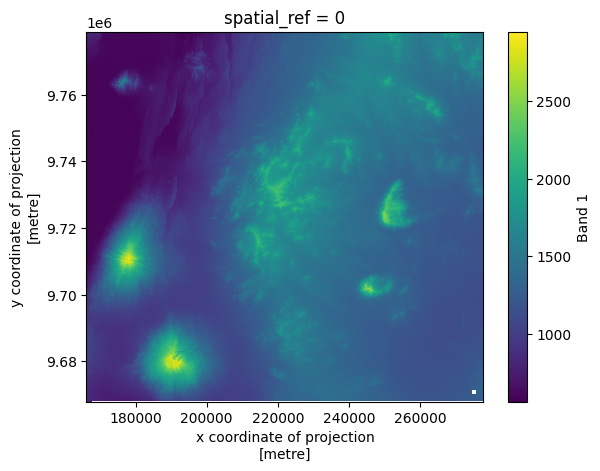

In [18]:
data_utm["elevation"].plot()